<a href="https://colab.research.google.com/github/Tiabet/NLP/blob/master/Review_classification_4types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tqdm import tqdm

import torch

import pandas as pd
import matplotlib.pyplot as plt

데이터 EDA

In [6]:
df_train = pd.read_csv("drive/MyDrive/train_data.csv")
df_test =   pd.read_csv("drive/MyDrive/test_data.csv")

In [7]:
df_train

,sentences,label
0,굿입니다~~~~~~,3
1,넘너무빠르고 맛있어여 ㅎㅎ,1
2,감사합니다!!!!!!!,3
3,잘먹었습니다 감사합니다,1
4,배달만 개선되묜 좋겟다..,2
...,...,...
93,??????????,3
94,너무맛있어요. 서비스 감사합니다. 밀크티가 정말 맛있네요,1
95,처음 시켜봤는데 엄청 맛있네요 잘먹었습니다 !,1
96,크림브뤨레라뇨...대박이에여 어떻게 리뷰 이벤트로 크로플을 주시는거죠...! 사장님...,1


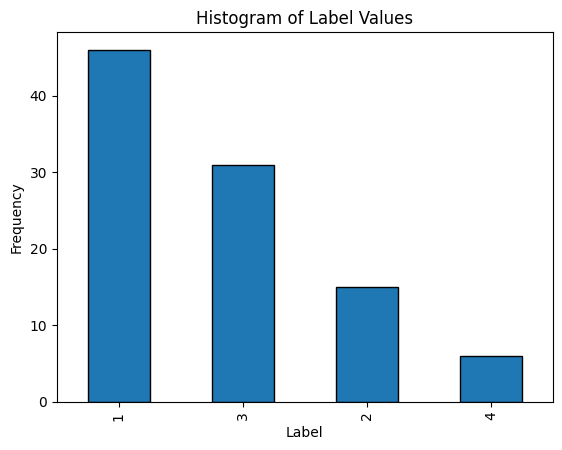

In [28]:
label_counts = df_train['label'].value_counts()

# Plot the histogram
label_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Label Values')
plt.show()

모델 로드

In [31]:
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")
model = AutoModel.from_pretrained("beomi/KcELECTRA-base-v2022")

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(54343, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

one-shot learning

In [56]:
model.eval()

preds = []

for idx in tqdm(range(len(df_test))):
        row = df_test.iloc[idx]

        random_1 = df_train[df_train['label']==1].sample(1)
        random_2 = df_train[df_train['label']==2].sample(1)
        random_3 = df_train[df_train['label']==3].sample(1)
        random_4 = df_train[df_train['label']==4].sample(1)

        example_sentence = f"""
        주어진 리뷰가 긍정적인 리뷰면 1, 부정적인 리뷰면 2, 무의미한 리뷰면 3, 악의적인 리뷰면 4를 반환하세요. \

        # 예시

        문장1 : {random_1['sentences']} -> 1 \
        문장2 : {random_2['sentences']} -> 2 \
        문장3 : {random_3['sentences']} -> 3 \
        문장4 : {random_4['sentences']} -> 4 \

        # 문제
        문장 :
        """

        prompt = example_sentence + " " + row['sentences']
        inputs = tokenizer(prompt, return_tensors="pt")
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            preds.append(outputs)



100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


In [67]:
logtis = outputs[0].detach().cpu()

In [68]:
result = logtis.argmax(-1)

In [82]:
tokenizer.decode(outputs[0])

TypeError: ignored

In [83]:
outputs

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[ 0.4040,  0.6139, -0.1427,  ..., -0.2219, -0.9581, -0.1697],
         [ 0.0299,  0.0225, -0.2524,  ..., -0.1999,  0.2508,  0.0237],
         [-0.0404,  0.0062,  0.2453,  ..., -0.2936,  0.0191,  0.8768],
         ...,
         [ 0.6460, -0.3624,  0.5810,  ...,  0.1254, -0.3841,  0.8637],
         [ 0.4542, -0.2831, -0.4944,  ..., -0.1670, -0.3797, -0.1246],
         [ 0.4040,  0.6139, -0.1427,  ..., -0.2219, -0.9581, -0.1697]]],
       device='cuda:0'), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [84]:
# Assuming outputs is an instance of BaseModelOutputWithPastAndCrossAttentions
last_hidden_state = outputs.last_hidden_state

# For language modeling, you might want to get the predicted sequence
predicted_sequence = torch.argmax(last_hidden_state, dim=-1).tolist()

In [92]:
# Decode the sequence using the tokenizer
decoded_output = tokenizer.decode(predicted_sequence[0])

In [93]:
decoded_output

'= ๑ 最 ๑ 最 { 最 ๑ 点 { { 最 ๑ ˘ ๑ 最 { 最 ๑ ˘ ๑ { 最 ๑ 最 ๑ 最 ๑ 最 名 最 最 名 最 山 最 最 最 ๑ 最 ๑ 最 最 ๑ 最 最 名 港 最 { 名 最 { 最 最 名 名 最 { 府 { { 名 最 最 { ๑ ↑ ᗜ 最 ▶ 最 最 ↑ { { ๑ ๑ 导 ๑ ” 名 ๑ ๑ ๑ ๑ ๑ 最 最 名 最 ๑ 最 最 最 名 最 { 府 { { ▷ 最 最 { ๑ ↑ ✚ 最 ๑ ๑ 名 最 ๑ 名 名 ๑ ๑ 名 最 最 名 最 最 最 最 最 名 最 { 府 { { ▷ 最 最 { ๑ ↑ ✚ 最 ๑ ๑ ㅂ 最 最 ๑ 最 最 ๑ 最 ๑ 名 ๑ 名 ㅍ ๑ 最 ๑ ๑ ๑ ๑ ๑ ๑ ๑ ๑ 最 最 最 そ ↘ 最 最 最 最 最 最 最 最 名 最 { 府 { { ๑ 最 最 { ๑ ↑ ๑ ” ” 最 ๑ 最 最 ๑ 名 ๑ ๑ 最 ๑ ๑ ๑ 最 ๑ 名 ๑ 最 ๑ ๑ 名 最 ๑ 名 最 ๑ ๑ 最 ๑ ๑ 府 ↘ ='